# Copper Track Defect Analysis Model Lifecycle

![AI Lifecycle](./assets/lifecycle.png)


## Step 3: Data Exploration

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from ultralytics import YOLO
from ultralytics.utils.metrics import DetMetrics

import sys
sys.path.insert(0, '..')
from yolo_visualize import sample_yolo_dataset

In [2]:
%matplotlib inline

In [3]:
FINAL_DATA_DIR = Path("./final_track_data")
LARGE_IMAGES_DATA = Path("./large_images_data")

In [4]:
CLASSES = [
    "Short",
    "Spur",
    "Spurious copper",
    "Open",
    "Mouse bite",
    "Hole breakout",
    "Conductor scratch",
    "Conductor foreign object",
    "Base material foreign object",
    "Missing hole",
]

SHORT = 0
SPUR = 1  # Extra copper protruding out of the copper track
SPURIOUS_COPPER = 2  # Extra copper outside of a track
OPEN = 3
MOUSE_BITE = 4  # Copper removed from the track
HOLE_BREAKOUT = 5  # Hole misaligned
SCRATCH = 6
CONDUCTOR_FOREIGN_OBJECT = 7
BASE_MATERIAL_FOREIGN_OBJECT = 8
MISSING_HOLE = 9

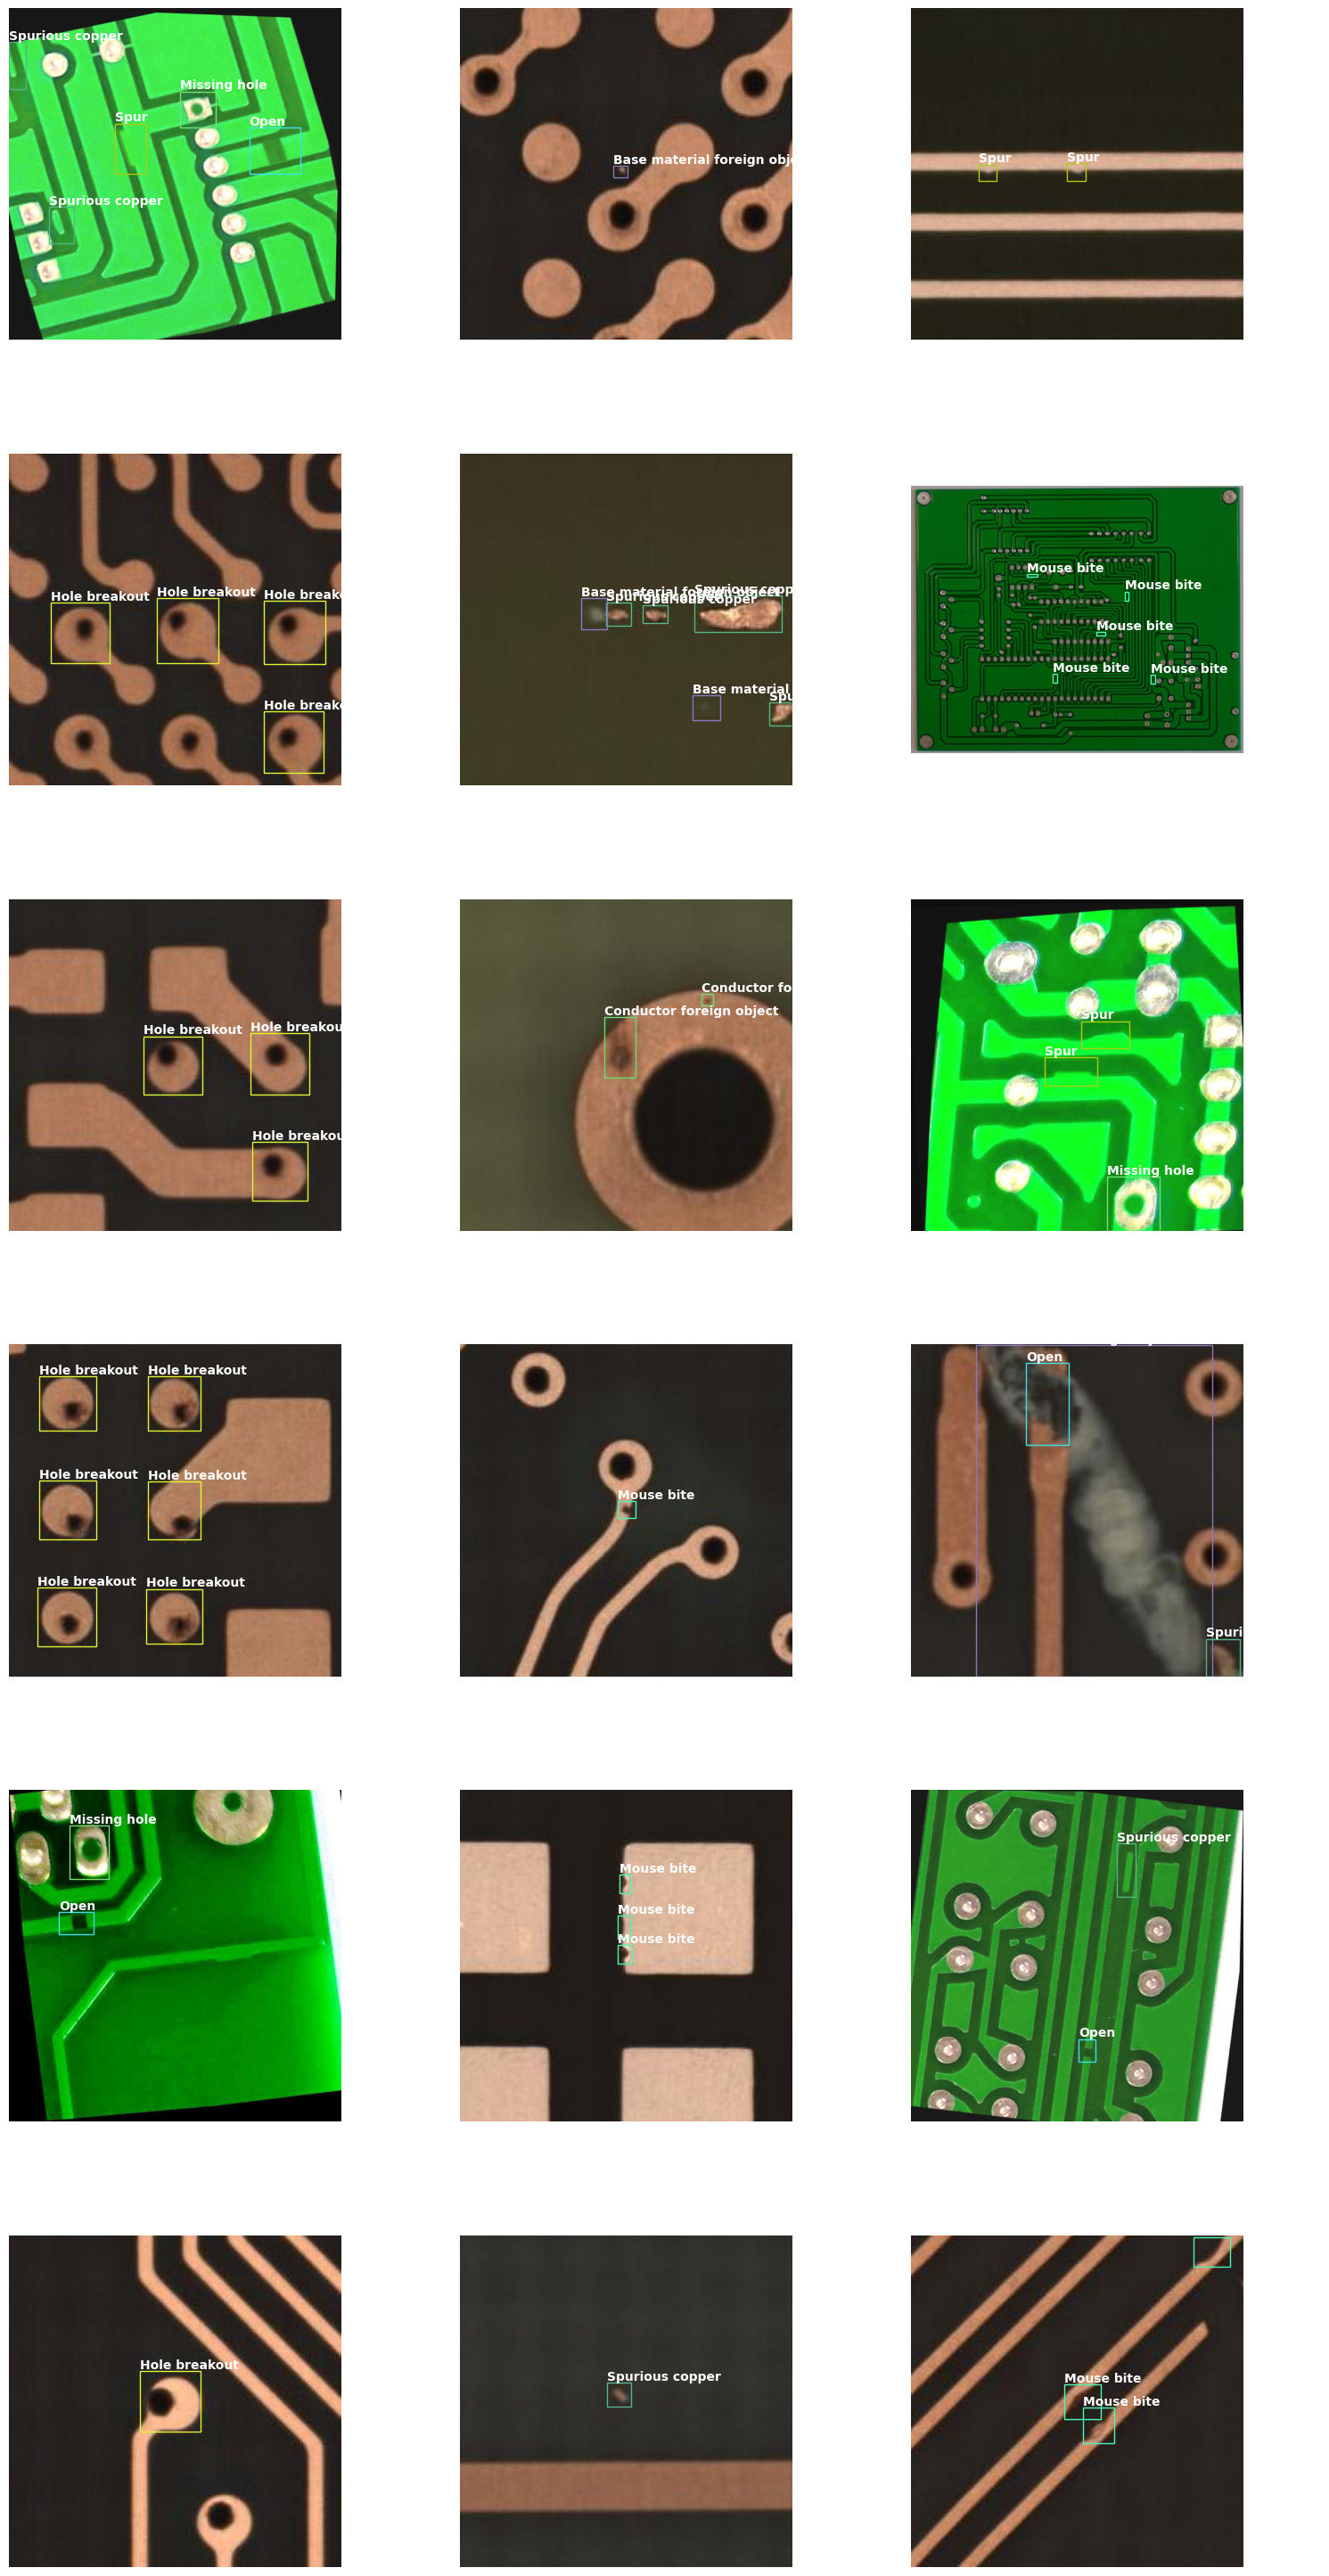

In [6]:
sample_yolo_dataset(FINAL_DATA_DIR / "train", CLASSES)

### Step 4: Modelling: Train a YOLOv11 Model

In [ ]:
model_general = YOLO("yolo11n.pt")

# Train the model
results = model_general.train(
    data=FINAL_DATA_DIR / "data.yaml",
    device=0,
    batch=-1,
    save_period=3,
    save=True,
    cache="disk",
    amp=True,
    freeze=10,
    patience=5,
    epochs=50,
    imgsz=640,
    hsv_h=0.5,
    hsv_s=0.7,
    hsv_v=0.6,
    degrees=180,
    translate=0.3,
    scale=0.5,
    shear=30,
    perspective=0.001,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0.0,
    erasing=0.0,
    bgr=0.0,
    mixup=0.0,
    cutmix=0.0,
    auto_augment=0.0,
)

New https://pypi.org/project/ultralytics/8.3.155 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=0.0, batch=-1, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./final_track_data/data.yaml, degrees=180, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.5, hsv_s=0.7, hsv_v=0.6, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False

train: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\train\labels.cache... 7329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7329/7329 [00:00<?, ?it/s]
train: Caching images (10.8GB Disk): 100%|██████████| 7329/7329 [06:07<00:00, 19.92it/s] 


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 1050 Ti) 4.00G total, 0.12G reserved, 0.05G allocated, 3.83G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2591790        6.45         0.434         100.5         396.6        (1, 3, 640, 640)                    list
     2591790        12.9         0.560         41.74         108.3        (2, 3, 640, 640)                    list
     2591790        25.8         0.742         51.66         82.04        (4, 3, 640, 640)                    list
     2591790        51.6         1.076         67.78         115.4        (8, 3, 640, 640)                    list
     2591790       103.2         1.808         148.8           220       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 18 for CUDA:0 2.15G/4.00G (54%) 
train: Fast image access  (ping: 0.10.0 ms, read: 73.9102

train: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\train\labels.cache... 7329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7329/7329 [00:00<?, ?it/s]
train: Caching images (10.8GB Disk): 100%|██████████| 7329/7329 [00:00<00:00, 13652.62it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 0.20.2 MB/s, size: 7.3 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:55<00:00, 28.59it/s] 


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005625000000000001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.55G       2.19      4.713      1.995          3        640: 100%|██████████| 408/408 [06:14<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:56<00:00,  1.26s/it]


                   all       1598       3404      0.151      0.184     0.0998     0.0301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.33G      2.026      3.403      1.797          5        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


                   all       1598       3404      0.275       0.27       0.18     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.33G      2.014      2.777      1.794          5        640: 100%|██████████| 408/408 [04:39<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


                   all       1598       3404      0.271      0.312      0.216     0.0731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.36G      1.973      2.426      1.759          3        640: 100%|██████████| 408/408 [04:41<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43<00:00,  1.02it/s]


                   all       1598       3404      0.423      0.378      0.311      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.33G      1.939      2.227      1.721          5        640: 100%|██████████| 408/408 [04:34<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:50<00:00,  1.12s/it]


                   all       1598       3404      0.434      0.343      0.307      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.33G      1.919      2.114      1.701          4        640: 100%|██████████| 408/408 [04:34<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:48<00:00,  1.09s/it]


                   all       1598       3404       0.48      0.373      0.333      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.33G      1.902      2.021      1.686          5        640: 100%|██████████| 408/408 [04:35<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:49<00:00,  1.10s/it]


                   all       1598       3404      0.477      0.392      0.362      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.34G      1.882      1.966      1.662          7        640: 100%|██████████| 408/408 [04:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:49<00:00,  1.09s/it]


                   all       1598       3404      0.457      0.421      0.393      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.34G      1.867      1.899      1.644         13        640: 100%|██████████| 408/408 [04:37<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:46<00:00,  1.04s/it]


                   all       1598       3404       0.52      0.401      0.385      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.34G      1.858      1.852      1.625          8        640: 100%|██████████| 408/408 [04:34<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:46<00:00,  1.03s/it]


                   all       1598       3404      0.569      0.443      0.435      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.35G      1.835      1.805      1.612          7        640: 100%|██████████| 408/408 [04:47<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:49<00:00,  1.09s/it]


                   all       1598       3404      0.558      0.416      0.425      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.34G      1.828      1.768      1.597          7        640: 100%|██████████| 408/408 [04:47<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:51<00:00,  1.15s/it]


                   all       1598       3404      0.569       0.43      0.442      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.33G      1.814      1.745      1.592          5        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:49<00:00,  1.10s/it]


                   all       1598       3404      0.551      0.465      0.461      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.35G      1.812      1.721      1.589          4        640: 100%|██████████| 408/408 [04:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:49<00:00,  1.09s/it]


                   all       1598       3404      0.584      0.425      0.458      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.39G      1.797      1.694      1.573          2        640: 100%|██████████| 408/408 [04:28<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:46<00:00,  1.03s/it]


                   all       1598       3404      0.595       0.47      0.492      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.35G      1.779      1.653       1.56          3        640: 100%|██████████| 408/408 [04:28<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


                   all       1598       3404      0.571      0.474      0.484      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.33G      1.787      1.642      1.553          5        640: 100%|██████████| 408/408 [04:30<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:45<00:00,  1.01s/it]


                   all       1598       3404      0.579      0.464      0.488      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.34G      1.771      1.617      1.547          6        640: 100%|██████████| 408/408 [04:24<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:44<00:00,  1.01it/s]


                   all       1598       3404      0.603      0.492      0.498      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.36G      1.769      1.599      1.538          5        640: 100%|██████████| 408/408 [04:28<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:44<00:00,  1.00it/s]


                   all       1598       3404      0.594      0.475      0.508      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.33G      1.759      1.577      1.532          5        640: 100%|██████████| 408/408 [04:29<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


                   all       1598       3404      0.604        0.5      0.523      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.33G      1.764      1.565      1.536          4        640: 100%|██████████| 408/408 [04:25<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404      0.648      0.462      0.531      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.33G      1.745      1.543      1.525          6        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


                   all       1598       3404      0.573      0.524      0.536      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.33G       1.74      1.518      1.513          8        640: 100%|██████████| 408/408 [04:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.10it/s]


                   all       1598       3404       0.62      0.508      0.538      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.39G      1.741      1.505      1.502          5        640: 100%|██████████| 408/408 [04:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


                   all       1598       3404      0.649      0.494      0.538      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.35G       1.74        1.5      1.505          5        640: 100%|██████████| 408/408 [04:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


                   all       1598       3404      0.631       0.52      0.553      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.34G      1.737      1.484        1.5          3        640: 100%|██████████| 408/408 [04:24<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


                   all       1598       3404      0.623      0.535      0.568       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.33G      1.732      1.468      1.493          4        640: 100%|██████████| 408/408 [04:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404       0.64      0.505      0.548       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.33G      1.725      1.448      1.484          4        640: 100%|██████████| 408/408 [04:35<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:44<00:00,  1.01it/s]


                   all       1598       3404      0.641      0.493      0.547      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.33G      1.719      1.435      1.483          7        640: 100%|██████████| 408/408 [04:26<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


                   all       1598       3404      0.636      0.525      0.562      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.33G       1.71      1.426      1.478          5        640: 100%|██████████| 408/408 [04:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


                   all       1598       3404      0.657      0.521      0.569      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.33G      1.719      1.428      1.478          5        640: 100%|██████████| 408/408 [04:26<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404      0.647      0.542      0.579      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.33G      1.707      1.408      1.473          3        640: 100%|██████████| 408/408 [04:25<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


                   all       1598       3404      0.635      0.537      0.582       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.33G      1.694      1.399      1.457          4        640: 100%|██████████| 408/408 [04:29<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


                   all       1598       3404      0.683      0.528      0.585      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.33G      1.693       1.38      1.461          8        640: 100%|██████████| 408/408 [04:42<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404      0.659      0.555      0.601      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.33G      1.688      1.376      1.454          4        640: 100%|██████████| 408/408 [04:42<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404      0.674      0.539      0.588      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.33G      1.689      1.379      1.455          7        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


                   all       1598       3404      0.667      0.532      0.581      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.33G      1.693      1.373      1.455          5        640: 100%|██████████| 408/408 [04:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


                   all       1598       3404      0.666      0.544      0.591      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.39G      1.676      1.353      1.446          5        640: 100%|██████████| 408/408 [04:34<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


                   all       1598       3404      0.682      0.548      0.602      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.33G      1.674      1.347      1.446          3        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


                   all       1598       3404      0.671      0.549        0.6      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.33G      1.657      1.336      1.438          4        640: 100%|██████████| 408/408 [04:28<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


                   all       1598       3404      0.665      0.552      0.597      0.263
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.33G      1.666      1.321      1.437          7        640: 100%|██████████| 408/408 [04:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]

                   all       1598       3404      0.679      0.554      0.602      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.39G      1.668      1.321       1.44          4        640: 100%|██████████| 408/408 [04:33<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


                   all       1598       3404      0.679      0.542      0.596      0.267
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

42 epochs completed in 3.777 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 5.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


                   all       1598       3404      0.668      0.545      0.592      0.272
                 Short        111        186      0.641      0.575      0.582      0.267
                  Spur        328        720      0.695      0.503      0.576      0.193
       Spurious copper        201        303      0.574      0.564      0.557      0.234
                  Open        233        333      0.661      0.652      0.652      0.269
            Mouse bite        291        461      0.631      0.505      0.541      0.188
         Hole breakout        198        444      0.772       0.89      0.918      0.649
     Conductor scratch        187        298      0.469      0.396      0.386      0.173
Conductor foreign object        221        315      0.598      0.441      0.498      0.211
Base material foreign object        217        250      0.676       0.66       0.69      0.259
          Missing hole         24         94      0.961      0.264      0.515       0.28
Speed: 0.4ms 

The model works fairly well, but it has some issues:
 - The model that we have trained above works well only on small cropped images of PCBs, not larger images. 
 - This is because the dataset has data from multiple sources, most of which include small 244x244 images of PCBs.
 - So we must train the best model from the above step on the larger full PCB images. (This is essentially a form of custom transfer learning.).
 - The best model is at ./runs/detect/train6/weights/best.pt, we will copy it to ./yolo11n_best_general.pt

In [ ]:
model_large_img = YOLO("yolo11n_best_general.pt")

In [ ]:
# Train the model on large images data
results = model_large_img.train(
    data=LARGE_IMAGES_DATA / "data.yaml",
    resume=True,
    device=0,
    batch=-1,
    save_period=3,
    save=True,
    cache="disk",
    amp=True,
    freeze=10,
    patience=5,
    epochs=50,
    imgsz=640,
    hsv_h=0.5,
    hsv_s=0.7,
    hsv_v=0.6,
    degrees=180,
    translate=0.3,
    scale=0.25,
    shear=20,
    perspective=0.001,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0.0,
    erasing=0.0,
    bgr=0.0,
    mixup=0.0,
    cutmix=0.0,
    auto_augment=0.0,
    dropout=0.5,
)

New https://pypi.org/project/ultralytics/8.3.155 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=0.0, batch=-1, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=large_images_data\data.yaml, degrees=180, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=50, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.5, hsv_s=0.7, hsv_v=0.6, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n_best_general.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, op

train: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\train\labels... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:09<00:00, 52.08it/s]

train: New cache created: E:\PythonProjects\pcb-defect-detection\large_images_data\train\labels.cache



train: Caching images (8.1GB Disk): 100%|██████████| 485/485 [04:11<00:00,  1.93it/s]

AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 1050 Ti) 4.00G total, 0.12G reserved, 0.07G allocated, 3.81G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     2591790        6.45         0.434         93.53         436.7        (1, 3, 640, 640)                    list
     2591790        12.9         0.566         52.54         106.1        (2, 3, 640, 640)                    list
     2591790        25.8         0.734          68.4          90.7        (4, 3, 640, 640)                    list
     2591790        51.6         1.053         83.69         99.11        (8, 3, 640, 640)                    list
     2591790       103.2         1.768         143.5         292.9       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 18 for CUDA:0 2.13G/4.00G (53%) 
train: Fast image access  (ping: 0.10.0 ms, read: 372.6752.5 MB/s, size: 1438.8 KB)


train: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\train\labels.cache... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:00<?, ?it/s]
train: Caching images (8.1GB Disk): 100%|██████████| 485/485 [00:00<00:00, 13338.21it/s]


val: Fast image access  (ping: 257.2257.1 ms, read: 8.312.4 MB/s, size: 1220.9 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:23<00:00,  4.46it/s]


val: New cache created: E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache


val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005625000000000001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.55G      2.557      3.263      1.351         71        640: 100%|██████████| 27/27 [02:12<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.86s/it]


                   all        104        448      0.435      0.254      0.251     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.55G      2.191      2.467       1.16         70        640: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.28s/it]


                   all        104        448       0.51      0.258      0.305      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.55G      2.165      2.348      1.151         68        640: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all        104        448      0.422      0.266      0.272      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.55G      2.152      2.336      1.146         60        640: 100%|██████████| 27/27 [01:59<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


                   all        104        448      0.455      0.298      0.316      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.55G      2.137       2.27      1.135         69        640: 100%|██████████| 27/27 [01:50<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all        104        448      0.525      0.311      0.342      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.55G      2.114      2.208      1.124         73        640: 100%|██████████| 27/27 [01:38<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        104        448      0.488      0.319      0.333      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.55G      2.084      2.114       1.13         66        640: 100%|██████████| 27/27 [01:57<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

                   all        104        448      0.519      0.277       0.32       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.55G      2.101      2.148      1.121         61        640: 100%|██████████| 27/27 [01:25<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all        104        448      0.565      0.322      0.355      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.55G      2.067      2.055       1.12         70        640: 100%|██████████| 27/27 [01:45<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

                   all        104        448      0.589      0.318      0.364      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.55G      2.084      2.121      1.119         63        640: 100%|██████████| 27/27 [01:42<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

                   all        104        448      0.622      0.292      0.342       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.55G       2.04      2.072      1.105         63        640: 100%|██████████| 27/27 [01:24<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

                   all        104        448      0.583      0.321      0.367       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.54G      1.988      1.999      1.093         64        640: 100%|██████████| 27/27 [01:42<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


                   all        104        448      0.555      0.357      0.371      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.55G      2.055      2.035      1.103         59        640: 100%|██████████| 27/27 [01:25<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all        104        448       0.59      0.291      0.337      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.55G      1.992      2.029      1.092         65        640: 100%|██████████| 27/27 [01:39<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.49s/it]

                   all        104        448      0.579      0.339      0.371      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.55G      2.015      2.007      1.104         76        640: 100%|██████████| 27/27 [01:31<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


                   all        104        448      0.471       0.37       0.37      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.55G      2.062      2.059      1.102         68        640: 100%|██████████| 27/27 [01:14<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

                   all        104        448      0.515      0.342      0.357      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.55G       2.04      1.997      1.086         71        640: 100%|██████████| 27/27 [01:20<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.46s/it]

                   all        104        448      0.491      0.369      0.369      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.55G      2.001      1.938      1.089         64        640: 100%|██████████| 27/27 [01:27<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all        104        448      0.591      0.356      0.396      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.55G      2.008      1.942      1.088         68        640: 100%|██████████| 27/27 [01:35<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


                   all        104        448      0.523      0.391      0.408      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.55G      1.987      1.959      1.087         69        640: 100%|██████████| 27/27 [01:12<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

                   all        104        448      0.473       0.41      0.404      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.55G      2.004       1.95      1.081         60        640: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

                   all        104        448      0.568      0.395      0.407      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.55G       2.05       1.94      1.093         67        640: 100%|██████████| 27/27 [01:22<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        104        448      0.498      0.417      0.415      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.55G      1.989      1.921      1.084         59        640: 100%|██████████| 27/27 [01:26<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        104        448       0.48      0.391      0.409      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.55G      2.006       1.88       1.09         58        640: 100%|██████████| 27/27 [01:26<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


                   all        104        448      0.502      0.352       0.38      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.55G      2.018       1.91      1.076         73        640: 100%|██████████| 27/27 [01:17<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


                   all        104        448      0.516      0.377        0.4       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.55G      1.968      1.851      1.074         61        640: 100%|██████████| 27/27 [01:20<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


                   all        104        448      0.582      0.376      0.422      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.55G          2       1.94      1.076         62        640: 100%|██████████| 27/27 [01:18<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]

                   all        104        448      0.564      0.406      0.413      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.55G      1.998      1.872      1.085         63        640: 100%|██████████| 27/27 [01:18<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]


                   all        104        448      0.533      0.385      0.393      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.55G      1.915      1.838      1.067         57        640: 100%|██████████| 27/27 [01:24<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


                   all        104        448      0.546      0.395       0.41      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.55G      1.961      1.822      1.073         66        640: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


                   all        104        448      0.515      0.391      0.418      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.55G      1.962      1.875      1.061         59        640: 100%|██████████| 27/27 [01:31<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]

                   all        104        448      0.553      0.385      0.415      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.55G      1.939      1.828      1.058         61        640: 100%|██████████| 27/27 [01:06<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


                   all        104        448      0.535      0.402      0.421      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.55G      1.954      1.814      1.066         69        640: 100%|██████████| 27/27 [01:09<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


                   all        104        448      0.562      0.382      0.415      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.55G      1.964      1.842       1.06         57        640: 100%|██████████| 27/27 [01:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

                   all        104        448      0.553      0.391       0.41      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.55G      1.933      1.768      1.063         70        640: 100%|██████████| 27/27 [01:12<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


                   all        104        448      0.543      0.371      0.395      0.181
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

35 epochs completed in 1.003 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 5.5MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


                   all        104        448      0.517       0.39      0.418      0.196
                 Short         15         56      0.438      0.304      0.317      0.139
                  Spur         13         55      0.343      0.273      0.251      0.117
       Spurious copper         20         91      0.593      0.396      0.404      0.188
                  Open         18         72      0.638      0.417      0.474       0.18
            Mouse bite         18         85      0.635      0.376      0.424      0.176
          Missing hole         20         89      0.454      0.573      0.638      0.378
Speed: 0.7ms preprocess, 11.3ms inference, 0.0ms loss, 15.6ms postprocess per image
Results saved to runs\detect\train7


Contine training with different parameters:

In [ ]:
model_large_img = YOLO("yolo11n_best_large_img.pt")

In [ ]:
results = model_large_img.train(
    data=LARGE_IMAGES_DATA / "data.yaml",
    device=0,
    batch=-1,
    save_period=3,
    save=True,
    cache="disk",
    amp=True,
    plots=True,
    freeze=9,
    patience=7,
    epochs=50,
    imgsz=640,
    hsv_h=0.5,
    hsv_s=0.7,
    hsv_v=0.6,
    degrees=90,
    translate=0.1,
    scale=0.35,
    shear=5,
    perspective=0.001,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0.0,
    erasing=0.0,
    bgr=0.0,
    mixup=0.0,
    cutmix=0.0,
    auto_augment=0.0,
    dropout=0.5,
)

New https://pypi.org/project/ultralytics/8.3.155 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=0.0, batch=-1, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=large_images_data\data.yaml, degrees=90, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.5, dynamic=False, embed=None, epochs=50, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=9, half=False, hsv_h=0.5, hsv_s=0.7, hsv_v=0.6, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n_best_large_track.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, 

train: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\train\labels.cache... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:00<?, ?it/s]
train: Caching images (8.1GB Disk): 100%|██████████| 485/485 [00:00<00:00, 1086.43it/s]


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce GTX 1050 Ti) 4.00G total, 0.12G reserved, 0.05G allocated, 3.83G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2591790        6.45         0.440         109.3         406.7        (1, 3, 640, 640)                    list
     2591790        12.9         0.577         46.85         109.4        (2, 3, 640, 640)                    list
     2591790        25.8         0.747          62.5         93.75        (4, 3, 640, 640)                    list
     2591790        51.6         1.082         78.09         93.79        (8, 3, 640, 640)                    list
     2591790       103.2         1.825         140.7           250       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 17 for CUDA:0 2.08G/4.00G (52%) 
train: Fast image access  (ping: 0.10.0 ms, read: 30.56.9

train: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\train\labels.cache... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:00<?, ?it/s]
train: Caching images (8.1GB Disk): 100%|██████████| 485/485 [00:00<00:00, 15535.05it/s]


val: Fast image access  (ping: 506.6507.5 ms, read: 1.51.2 MB/s, size: 1220.9 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:15<00:00,  6.80it/s]


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00053125), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.54G       1.95      1.826      1.068         38        640: 100%|██████████| 29/29 [02:00<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        104        448       0.57      0.368        0.4      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       1.3G      1.892      1.818      1.052         43        640: 100%|██████████| 29/29 [02:04<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        104        448      0.576      0.385      0.418      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.3G      1.922      1.822      1.049         39        640: 100%|██████████| 29/29 [01:33<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


                   all        104        448      0.558      0.316      0.398      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.3G      1.902      1.757      1.046         40        640: 100%|██████████| 29/29 [01:40<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]

                   all        104        448      0.579      0.407      0.426      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.3G      1.895      1.783       1.06         40        640: 100%|██████████| 29/29 [01:35<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]

                   all        104        448      0.518      0.414      0.421      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.3G      1.905      1.735      1.051         38        640: 100%|██████████| 29/29 [01:48<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        104        448      0.736      0.347      0.439      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.3G       1.87      1.715      1.044         32        640: 100%|██████████| 29/29 [01:48<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

                   all        104        448      0.578      0.373      0.413      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.29G      1.903      1.795      1.043         37        640: 100%|██████████| 29/29 [01:26<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]

                   all        104        448      0.576      0.377      0.445      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       1.3G      1.878      1.707      1.047         40        640: 100%|██████████| 29/29 [01:33<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

                   all        104        448      0.555      0.368      0.427      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       1.3G      1.895      1.754      1.045         38        640: 100%|██████████| 29/29 [01:34<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        104        448      0.566      0.394      0.406      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.3G      1.892      1.715      1.049         39        640: 100%|██████████| 29/29 [01:44<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        104        448      0.621      0.377      0.435      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.29G      1.843      1.652      1.044         38        640: 100%|██████████| 29/29 [01:35<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        104        448       0.63      0.411      0.467      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.3G      1.894      1.731      1.035         34        640: 100%|██████████| 29/29 [01:22<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]

                   all        104        448      0.586       0.41      0.456      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.3G      1.829      1.693      1.038         40        640: 100%|██████████| 29/29 [01:28<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

                   all        104        448      0.568      0.461      0.484      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.3G      1.881      1.672      1.041         42        640: 100%|██████████| 29/29 [01:33<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


                   all        104        448      0.619      0.409      0.449      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.29G      1.844      1.706      1.033         40        640: 100%|██████████| 29/29 [01:21<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

                   all        104        448      0.542      0.426      0.439      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.3G      1.844      1.653       1.03         40        640: 100%|██████████| 29/29 [01:16<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


                   all        104        448       0.51      0.406      0.442      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       1.3G      1.878      1.647      1.042         39        640: 100%|██████████| 29/29 [01:33<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


                   all        104        448      0.638      0.399       0.45      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       1.3G      1.854      1.641      1.038         37        640: 100%|██████████| 29/29 [01:24<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

                   all        104        448      0.666      0.383      0.449      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.29G      1.842      1.675      1.032         36        640: 100%|██████████| 29/29 [01:18<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all        104        448      0.574      0.437      0.466      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       1.3G       1.85       1.62      1.034         34        640: 100%|██████████| 29/29 [01:35<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

                   all        104        448      0.666      0.429      0.494      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       1.3G      1.852      1.637      1.032         39        640: 100%|██████████| 29/29 [01:22<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        104        448      0.667      0.408      0.461      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       1.3G      1.819      1.598       1.03         34        640: 100%|██████████| 29/29 [01:27<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        104        448      0.621      0.422       0.48       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.29G      1.787      1.583      1.026         39        640: 100%|██████████| 29/29 [01:13<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

                   all        104        448      0.596      0.429      0.479      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       1.3G      1.846        1.6      1.034         41        640: 100%|██████████| 29/29 [01:21<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all        104        448      0.629      0.403      0.463       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       1.3G      1.798      1.598      1.021         29        640: 100%|██████████| 29/29 [01:17<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        104        448      0.579      0.426      0.478      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       1.3G      1.813      1.541      1.023         34        640: 100%|██████████| 29/29 [01:20<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        104        448      0.677      0.435      0.485      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.29G      1.792      1.554      1.009         33        640: 100%|██████████| 29/29 [01:47<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        104        448        0.6      0.462       0.48      0.222


EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 21, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

28 epochs completed in 0.806 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 5.5MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


                   all        104        448      0.664      0.429      0.494      0.224
                 Short         15         56      0.491      0.357      0.371      0.169
                  Spur         13         55      0.883      0.274      0.409      0.166
       Spurious copper         20         91      0.495      0.429       0.46      0.214
                  Open         18         72      0.803      0.472      0.551       0.22
            Mouse bite         18         85       0.61      0.459      0.491      0.191
          Missing hole         20         89        0.7      0.584      0.679      0.383
Speed: 0.9ms preprocess, 8.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\detect\train8


The results of this are saved to "./yolo11n_best_large_img_retrain.pt". Let's test it now.

### Step 5: Evaluation:

Define an evalutation function that evaluates a model in 4 ways:
 - on the entire dataset
 - on the entire dataset, with single class (by combining all classes into i.e. consider all problem types as the same)
 - on the large PCB images dataset
 - on the large PCB images dataset, with single class

In [11]:
def eval_model(model: YOLO, model_name: str):
    results1: DetMetrics = model.val(
        data=FINAL_DATA_DIR / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        project=model_name,
        name="val_full_dataset",
    )
    results2 = model.val(
        data=FINAL_DATA_DIR / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        single_cls=True,
        project=model_name,
        name="val_full_dataset_single_cls",
    )
    results3: DetMetrics = model.val(
        data=LARGE_IMAGES_DATA / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        project=model_name,
        name="val_large_imgs_only",
    )
    results4: DetMetrics = model.val(
        data=LARGE_IMAGES_DATA / "data.yaml",
        device=0,
        batch=16,
        cache="disk",
        save_json=True,
        iou=0.7,
        plots=True,
        split="val",
        verbose=True,
        single_cls=True,
        project=model_name,
        name="val_large_imgs_only_single_cls",
    )
    r2 = results2.summary()
    r2[0]["class_name"] = "Combined"
    r4 = results4.summary()
    r4[0]["class_name"] = "Combined"
    return pd.concat(
        [
            pd.DataFrame(results1.summary()).set_index("class_name"),
            pd.DataFrame(r2).set_index("class_name"),
            pd.DataFrame(results3.summary()).set_index("class_name"),
            pd.DataFrame(r4).set_index("class_name"),
        ],
        axis=0,
        keys=["Full", "Full (Single Class)", "Large PCBs", "Large PCBs (Single Class)"],
    )

#### Evaluate the current best general model

In [ ]:
model_best_general = YOLO("yolo11n_best_general.pt")

In [27]:
model_best_general_res = eval_model(model_best_general, "yolo11n_general")
model_best_general_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.10.1 ms, read: 0.30.1 MB/s, size: 5.7 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 11329.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


                   all       1598       3404      0.665      0.542      0.587      0.271
                 Short        111        186      0.638      0.568      0.583      0.268
                  Spur        328        720      0.701      0.499      0.574      0.193
       Spurious copper        201        303      0.569      0.568      0.557      0.235
                  Open        233        333      0.667      0.652      0.653      0.268
            Mouse bite        291        461      0.621      0.497      0.526      0.185
         Hole breakout        198        444      0.771      0.893      0.918      0.651
     Conductor scratch        187        298      0.454      0.393      0.381      0.171
Conductor foreign object        221        315      0.594      0.438      0.493       0.21
Base material foreign object        217        250       0.68      0.656      0.689      0.257
          Missing hole         24         94       0.96      0.254      0.496      0.268
Speed: 0.6ms 

val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 5304.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


                   all       1598       3404      0.727      0.604      0.667      0.304
                 Short       1598       3404      0.727      0.604      0.667      0.304
Speed: 0.5ms preprocess, 9.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Saving yolo11n_general\val_full_dataset_single_cls2\predictions.json...
Results saved to yolo11n_general\val_full_dataset_single_cls2
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.50.2 ms, read: 40.411.8 MB/s, size: 1360.4 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 3433.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


                   all        104        448       0.45      0.292      0.303      0.127
                 Short         15         56      0.186      0.304      0.206     0.0753
                  Spur         13         55      0.351      0.218      0.162      0.061
       Spurious copper         20         91      0.457      0.222      0.278      0.128
                  Open         18         72      0.541      0.333       0.37      0.132
            Mouse bite         18         85      0.519      0.329      0.329       0.12
          Missing hole         20         89      0.645      0.347      0.471      0.247
Speed: 2.0ms preprocess, 9.7ms inference, 0.0ms loss, 4.7ms postprocess per image
Saving yolo11n_general\val_large_imgs_only2\predictions.json...
Results saved to yolo11n_general\val_large_imgs_only2
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.10.1 ms, read: 319.2632.6 MB/s, size: 1256.4 K

val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


                   all        104        448      0.497      0.315      0.347      0.141
                 Short        104        448      0.497      0.315      0.347      0.141
Speed: 2.8ms preprocess, 9.1ms inference, 0.0ms loss, 8.9ms postprocess per image
Saving yolo11n_general\val_large_imgs_only_single_cls2\predictions.json...
Results saved to yolo11n_general\val_large_imgs_only_single_cls2


box-p    box-r  \
                          class_name                                       
Full                      Short                         0.63775  0.56792   
                          Spur                          0.70119  0.49861   
                          Spurious copper               0.56876  0.56766   
                          Open                          0.66722  0.65165   
                          Mouse bite                    0.62108  0.49675   
                          Hole breakout                 0.77058  0.89265   
                          Conductor scratch             0.45449  0.39262   
                          Conductor foreign object      0.59384  0.43810   
                          Base material foreign object  0.67959  0.65600   
                          Missing hole                  0.95977  0.25386   
Full (Single Class)       Combined                      0.72731  0.60400   
Large PCBs                Short                         0.18621  0.30357   
                          Spur                          0.35149  0.21818   
                          Spurious copper               0.45723  0.22222   
                          Open                          0.54110  0.33333   
                          Mouse bite                    0.51851  0.32941   
                          Missing hole                  0.64520  0.34738   
Large PCBs (Single Class) Combined                      0.49684  0.31473   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.60081  0.27069   
                          Spur                          0.58280  0.27069   
                          Spurious copper               0.56821  0.27069   
                          Open                          0.65934  0.27069   
                          Mouse bite                    0.55200  0.27069   
                          Hole breakout                 0.82713  0.27069   
                          Conductor scratch             0.42129  0.27069   
                          Conductor foreign object      0.50421  0.27069   
                          Base material foreign object  0.66759  0.27069   
                          Missing hole                  0.40152  0.27069   
Full (Single Class)       Combined                      0.65994  0.30356   
Large PCBs                Short                         0.23083  0.12701   
                          Spur                          0.26924  0.12701   
                          Spurious copper               0.29908  0.12701   
                          Open                          0.41253  0.12701   
                          Mouse bite                    0.40287  0.12701   
                          Missing hole                  0.45161  0.12701   
Large PCBs (Single Class) Combined                      0.38535  0.14071   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.58708    0.20554  
                          Spur                            0.58708    0.20554  
                          Spurious copper                 0.58708    0.20554  
                          Open                            0.58708    0.20554  
                          Mouse bite                      0.58708    0.20554  
                          Hole breakout                   0.58708    0.20554  
                          Conductor scratch               0.58708    0.20554  
                          Conductor foreign object        0.58708    0.20554  
                          Base material foreign object    0.58708    0.20554  
                          Missing hole                    0.58708    0.20554  
Full (Single Class)       Combined                        0.66708   

#### Evaluate the current best large PCB image model

In [12]:
model_best_lt = YOLO("yolo11n_best_large_img_retrain.pt")

In [13]:
model_best_lt_res = eval_model(model_best_lt, "yolo11n_large_track_re")
model_best_lt_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 7.215.5 MB/s, size: 189.9 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 13231.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


                   all       1598       3404      0.324       0.17      0.188     0.0796
                 Short        111        186      0.433      0.194        0.2     0.0848
                  Spur        328        720      0.393      0.108      0.112      0.033
       Spurious copper        201        303      0.299      0.175      0.161     0.0695
                  Open        233        333      0.585      0.297      0.335      0.106
            Mouse bite        291        461      0.404      0.284      0.249     0.0735
         Hole breakout        198        444          0          0          0          0
     Conductor scratch        187        298          0          0          0          0
Conductor foreign object        221        315          0          0          0          0
Base material foreign object        217        250          1          0      0.324      0.136
          Missing hole         24         94       0.13      0.638      0.502      0.293
Speed: 0.5ms 

val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 1924.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:36<00:00,  2.78it/s]


                   all       1598       3404      0.374      0.243      0.222     0.0805
                 Short       1598       3404      0.374      0.243      0.222     0.0805
Speed: 0.5ms preprocess, 9.4ms inference, 0.0ms loss, 3.1ms postprocess per image
Saving yolo11n_large_track_re\val_full_dataset_single_cls2\predictions.json...
Results saved to yolo11n_large_track_re\val_full_dataset_single_cls2
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.40.0 ms, read: 248.1195.4 MB/s, size: 1321.2 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 3488.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.47s/it]


                   all        104        448      0.652       0.44      0.493      0.223
                 Short         15         56      0.471      0.375       0.37      0.167
                  Spur         13         55      0.888      0.289      0.395      0.161
       Spurious copper         20         91      0.507      0.451      0.467      0.216
                  Open         18         72      0.735      0.458      0.523      0.218
            Mouse bite         18         85       0.61      0.471      0.516      0.192
          Missing hole         20         89      0.699      0.596      0.684      0.385
Speed: 1.9ms preprocess, 13.7ms inference, 0.0ms loss, 6.8ms postprocess per image
Saving yolo11n_large_track_re\val_large_imgs_only\predictions.json...
Results saved to yolo11n_large_track_re\val_large_imgs_only
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.20.1 ms, read: 131.5198.3 MB/s, s

val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 10441.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


                   all        104        448      0.686      0.471      0.541      0.241
                 Short        104        448      0.686      0.471      0.541      0.241
Speed: 4.3ms preprocess, 8.7ms inference, 0.0ms loss, 8.1ms postprocess per image
Saving yolo11n_large_track_re\val_large_imgs_only_single_cls\predictions.json...
Results saved to yolo11n_large_track_re\val_large_imgs_only_single_cls


box-p    box-r  \
                          class_name                                       
Full                      Short                         0.43331  0.19355   
                          Spur                          0.39304  0.10833   
                          Spurious copper               0.29886  0.17492   
                          Open                          0.58518  0.29730   
                          Mouse bite                    0.40450  0.28416   
                          Hole breakout                 0.00000  0.00000   
                          Conductor scratch             0.00000  0.00000   
                          Conductor foreign object      0.00000  0.00000   
                          Base material foreign object  1.00000  0.00000   
                          Missing hole                  0.12982  0.63830   
Full (Single Class)       Combined                      0.37371  0.24324   
Large PCBs                Short                         0.47123  0.37500   
                          Spur                          0.88827  0.28919   
                          Spurious copper               0.50664  0.45140   
                          Open                          0.73531  0.45833   
                          Mouse bite                    0.61046  0.47059   
                          Missing hole                  0.69882  0.59551   
Large PCBs (Single Class) Combined                      0.68593  0.47098   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.26758  0.07956   
                          Spur                          0.16985  0.07956   
                          Spurious copper               0.22068  0.07956   
                          Open                          0.39428  0.07956   
                          Mouse bite                    0.33382  0.07956   
                          Hole breakout                 0.00000  0.07956   
                          Conductor scratch             0.00000  0.07956   
                          Conductor foreign object      0.00000  0.07956   
                          Base material foreign object  0.00000  0.07956   
                          Missing hole                  0.21576  0.07956   
Full (Single Class)       Combined                      0.29468  0.08047   
Large PCBs                Short                         0.41764  0.22321   
                          Spur                          0.43633  0.22321   
                          Spurious copper               0.47743  0.22321   
                          Open                          0.56469  0.22321   
                          Mouse bite                    0.53148  0.22321   
                          Missing hole                  0.64304  0.22321   
Large PCBs (Single Class) Combined                      0.55849  0.24095   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.18828    0.05953  
                          Spur                            0.18828    0.05953  
                          Spurious copper                 0.18828    0.05953  
                          Open                            0.18828    0.05953  
                          Mouse bite                      0.18828    0.05953  
                          Hole breakout                   0.18828    0.05953  
                          Conductor scratch               0.18828    0.05953  
                          Conductor foreign object        0.18828    0.05953  
                          Base material foreign object    0.18828    0.05953  
                          Missing hole                    0.18828    0.05953  
Full (Single Class)       Combined                        0.22235   

From this we see that the large image model, pretty much failed at the general classification & detection task, it only works well on the large images. 

So, we are going to scrap it and focus on the general model. And, then for deployment to work with larger images, we will take a large PCB image, split it up into many smaller PCB images, pass these smaller images to the model, and then consolidate the result to get the final prediction for the large PCB. For this we will use SAHI (Slicing Aided Hyper Inference (https://github.com/obss/sahi)).

But before we can do that, we have...

### Step 4: Modelling (Again): (Re)Train the YOLOv11 Model

The main thing we are changing now, is that we are now using freeze=9, i.e. making more of the model trainable, and mosaic=0.1 applying mosaic augmentation to 10% of all images.

In [ ]:
model_general_re = YOLO("yolo11n_best_general.pt")

In [10]:
results = model_general_re.train(
    data=FINAL_DATA_DIR / "data.yaml",
    device=0,
    batch=20,
    save_period=3,
    save=True,
    cache="disk",
    amp=True,
    plots=True,
    freeze=9,
    patience=6,
    epochs=50,
    imgsz=640,
    hsv_h=0.5,
    hsv_s=0.7,
    hsv_v=0.6,
    degrees=90,
    translate=0.1,
    scale=0.35,
    shear=5,
    perspective=0.001,
    flipud=0.5,
    fliplr=0.5,
    mosaic=0.1,
    close_mosaic=25,
    erasing=0.0,
    bgr=0.0,
    mixup=0.0,
    cutmix=0.0,
    auto_augment=0.0,
    dropout=0.5,
)

New https://pypi.org/project/ultralytics/8.3.155 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=0.0, batch=20, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=25, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=final_track_data\data.yaml, degrees=90, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.5, dynamic=False, embed=None, epochs=50, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=9, half=False, hsv_h=0.5, hsv_s=0.7, hsv_v=0.6, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./train14/weights/epoch39.pt, momentum=0.937, mosaic=0.1, multi_scale=False, name=train11, nbs=64, nms=False, opset=None,

train: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\train\labels.cache... 7329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7329/7329 [00:00<?, ?it/s]
train: Caching images (10.8GB Disk): 100%|██████████| 7329/7329 [00:00<00:00, 12463.93it/s]


val: Fast image access  (ping: 265.0312.3 ms, read: 0.10.1 MB/s, size: 5.6 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 7861.38it/s]


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.62G      1.563      1.078      1.322         12        640: 100%|██████████| 367/367 [12:44<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [02:08<00:00,  3.22s/it]


                   all       1598       3404      0.695      0.613      0.655      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.73G      1.586       1.12      1.346         18        640: 100%|██████████| 367/367 [13:06<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [02:14<00:00,  3.36s/it]


                   all       1598       3404      0.669      0.587      0.632      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.53G      1.609      1.163      1.357         19        640: 100%|██████████| 367/367 [10:14<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


                   all       1598       3404      0.649      0.596      0.627      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.57G      1.633      1.187      1.377         19        640: 100%|██████████| 367/367 [09:05<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [02:11<00:00,  3.29s/it]


                   all       1598       3404      0.646      0.602      0.632      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.58G      1.628      1.191      1.375         24        640: 100%|██████████| 367/367 [10:19<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


                   all       1598       3404      0.651      0.555      0.616      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.51G      1.632      1.193      1.385         23        640: 100%|██████████| 367/367 [06:54<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:30<00:00,  2.26s/it]


                   all       1598       3404      0.647      0.567      0.605       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.52G      1.628      1.177      1.371         13        640: 100%|██████████| 367/367 [06:46<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:29<00:00,  2.24s/it]


                   all       1598       3404      0.629      0.601      0.628      0.289
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

7 epochs completed in 1.376 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 5.5MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


                   all       1598       3404      0.695      0.613      0.655      0.324
                 Short        111        186       0.75      0.629      0.675      0.352
                  Spur        328        720      0.747      0.581      0.642      0.235
       Spurious copper        201        303      0.652      0.575      0.612      0.282
                  Open        233        333       0.71      0.694       0.72      0.326
            Mouse bite        291        461      0.649      0.561      0.602      0.214
         Hole breakout        198        444       0.91      0.914      0.968       0.72
     Conductor scratch        187        298        0.6        0.5      0.564      0.283
Conductor foreign object        221        315      0.542      0.523      0.526       0.24
Base material foreign object        217        250      0.677      0.768      0.749      0.309
          Missing hole         24         94       0.71      0.383      0.489      0.277
Speed: 0.4ms 

There was a training run that was interrupted in the middle but got excellent results, so we will import it and then save it to clean up anything that was not needed (like trainer & optimizer parameters).

In [ ]:
from ultralytics.utils.torch_utils import strip_optimizer

_ = strip_optimizer(
    "./runs/detect/train11/weights/best.pt", s="yolo11n_best_general_2.pt"
)

Optimizer stripped from ./runs/detect/train11/weights/best.pt, saved as yolo11n_best_general_2.pt, 5.5MB


### Step 5 (Again): (Re)Evaluation:

In [27]:
model_best_gen_2 = YOLO("yolo11n_best_general_2.pt")

In [28]:
model_best_gen_2_res = eval_model(model_best_gen_2, "yolo11n_general_2")
model_best_gen_2_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 0.40.2 MB/s, size: 6.1 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 11064.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


                   all       1598       3404      0.691      0.625      0.671      0.344
                 Short        111        186      0.759       0.64      0.698      0.384
                  Spur        328        720      0.762      0.532      0.639      0.236
       Spurious copper        201        303      0.618       0.64      0.649      0.313
                  Open        233        333      0.703      0.703      0.742      0.327
            Mouse bite        291        461      0.691      0.551       0.61      0.232
         Hole breakout        198        444      0.813      0.968      0.971      0.752
     Conductor scratch        187        298      0.572      0.554       0.56      0.299
Conductor foreign object        221        315      0.581      0.484      0.538      0.263
Base material foreign object        217        250      0.679      0.756      0.765      0.321
          Missing hole         24         94      0.737      0.418      0.542      0.313
Speed: 0.5ms 

val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 2179.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


                   all       1598       3404      0.772      0.658      0.741      0.377
                 Short       1598       3404      0.772      0.658      0.741      0.377
Speed: 0.6ms preprocess, 9.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Saving yolo11n_general_2\val_full_dataset_single_cls\predictions.json...
Results saved to yolo11n_general_2\val_full_dataset_single_cls
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.40.1 ms, read: 40.87.6 MB/s, size: 1383.2 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 6689.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:27<00:00,  3.98s/it]


                   all        104        448      0.533      0.388      0.391      0.178
                 Short         15         56      0.434      0.357       0.33      0.153
                  Spur         13         55      0.517      0.236      0.255     0.0966
       Spurious copper         20         91      0.478      0.429      0.389       0.18
                  Open         18         72      0.665      0.431      0.463      0.176
            Mouse bite         18         85      0.509        0.4      0.396      0.169
          Missing hole         20         89      0.594      0.476      0.517      0.292
Speed: 1.8ms preprocess, 10.7ms inference, 0.0ms loss, 6.6ms postprocess per image
Saving yolo11n_general_2\val_large_imgs_only\predictions.json...
Results saved to yolo11n_general_2\val_large_imgs_only
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 358.6705.3 MB/s, size: 1456.

val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 8776.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


                   all        104        448      0.599      0.424      0.438      0.192
                 Short        104        448      0.599      0.424      0.438      0.192
Speed: 2.8ms preprocess, 8.4ms inference, 0.0ms loss, 8.8ms postprocess per image
Saving yolo11n_general_2\val_large_imgs_only_single_cls\predictions.json...
Results saved to yolo11n_general_2\val_large_imgs_only_single_cls


box-p    box-r  \
                          class_name                                       
Full                      Short                         0.75861  0.63978   
                          Spur                          0.76153  0.53222   
                          Spurious copper               0.61793  0.64026   
                          Open                          0.70308  0.70270   
                          Mouse bite                    0.69113  0.55098   
                          Hole breakout                 0.81272  0.96760   
                          Conductor scratch             0.57191  0.55369   
                          Conductor foreign object      0.58090  0.48402   
                          Base material foreign object  0.67865  0.75600   
                          Missing hole                  0.73747  0.41842   
Full (Single Class)       Combined                      0.77179  0.65834   
Large PCBs                Short                         0.43373  0.35714   
                          Spur                          0.51660  0.23636   
                          Spurious copper               0.47770  0.42857   
                          Open                          0.66475  0.43056   
                          Mouse bite                    0.50888  0.40000   
                          Missing hole                  0.59376  0.47629   
Large PCBs (Single Class) Combined                      0.59917  0.42411   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.69415  0.34406   
                          Spur                          0.62655  0.34406   
                          Spurious copper               0.62890  0.34406   
                          Open                          0.70289  0.34406   
                          Mouse bite                    0.61315  0.34406   
                          Hole breakout                 0.88342  0.34406   
                          Conductor scratch             0.56265  0.34406   
                          Conductor foreign object      0.52805  0.34406   
                          Base material foreign object  0.71524  0.34406   
                          Missing hole                  0.53391  0.34406   
Full (Single Class)       Combined                      0.71057  0.37722   
Large PCBs                Short                         0.39173  0.17780   
                          Spur                          0.32433  0.17780   
                          Spurious copper               0.45181  0.17780   
                          Open                          0.52262  0.17780   
                          Mouse bite                    0.44792  0.17780   
                          Missing hole                  0.52858  0.17780   
Large PCBs (Single Class) Combined                      0.49666  0.19223   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.67146    0.29448  
                          Spur                            0.67146    0.29448  
                          Spurious copper                 0.67146    0.29448  
                          Open                            0.67146    0.29448  
                          Mouse bite                      0.67146    0.29448  
                          Hole breakout                   0.67146    0.29448  
                          Conductor scratch               0.67146    0.29448  
                          Conductor foreign object        0.67146    0.29448  
                          Base material foreign object    0.67146    0.29448  
                          Missing hole                    0.67146    0.29448  
Full (Single Class)       Combined                        0.74098   

General Model 3 was basically the above model but trained for longer.

In [29]:
model_best_gen_3 = YOLO("yolo11n_best_general_3.pt")

In [30]:
model_best_gen_3_res = eval_model(model_best_gen_3, "yolo11n_general_3")
model_best_gen_3_res

Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 0.40.3 MB/s, size: 6.1 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:00<00:00, 12940.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


                   all       1598       3404       0.69      0.616      0.656      0.326
                 Short        111        186      0.744      0.634       0.68      0.356
                  Spur        328        720      0.742      0.586      0.644      0.235
       Spurious copper        201        303      0.647      0.578      0.612      0.282
                  Open        233        333      0.702      0.694      0.719      0.327
            Mouse bite        291        461       0.64      0.563        0.6      0.214
         Hole breakout        198        444      0.906      0.912      0.968      0.721
     Conductor scratch        187        298      0.598      0.505      0.564      0.283
Conductor foreign object        221        315      0.532      0.524      0.526      0.241
Base material foreign object        217        250      0.673      0.768      0.749      0.312
          Missing hole         24         94      0.714      0.394        0.5      0.288
Speed: 0.6ms 

val: Scanning E:\PythonProjects\pcb-defect-detection\final_track_data\valid\labels.cache... 1598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1598/1598 [00:00<?, ?it/s]
val: Caching images (1.9GB Disk): 100%|██████████| 1598/1598 [00:01<00:00, 1442.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


                   all       1598       3404      0.775      0.665       0.74       0.36
                 Short       1598       3404      0.775      0.665       0.74       0.36
Speed: 0.5ms preprocess, 9.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Saving yolo11n_general_3\val_full_dataset_single_cls\predictions.json...
Results saved to yolo11n_general_3\val_full_dataset_single_cls
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.40.1 ms, read: 39.18.9 MB/s, size: 1108.1 KB)


val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 2510.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


                   all        104        448      0.504       0.34      0.339      0.152
                 Short         15         56      0.337      0.304      0.274      0.117
                  Spur         13         55      0.562      0.164      0.206      0.076
       Spurious copper         20         91      0.523      0.385      0.348      0.151
                  Open         18         72      0.587      0.361      0.409      0.169
            Mouse bite         18         85      0.415      0.365      0.324      0.134
          Missing hole         20         89      0.601      0.461      0.471      0.264
Speed: 2.5ms preprocess, 8.6ms inference, 0.0ms loss, 10.9ms postprocess per image
Saving yolo11n_general_3\val_large_imgs_only\predictions.json...
Results saved to yolo11n_general_3\val_large_imgs_only
Ultralytics 8.3.154  Python-3.12.4 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 377.7759.7 MB/s, size: 1271.

val: Scanning E:\PythonProjects\pcb-defect-detection\large_images_data\valid\labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]
val: Caching images (1.7GB Disk): 100%|██████████| 104/104 [00:00<00:00, 6917.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


                   all        104        448      0.535      0.389      0.379      0.165
                 Short        104        448      0.535      0.389      0.379      0.165
Speed: 2.0ms preprocess, 9.9ms inference, 0.0ms loss, 7.0ms postprocess per image
Saving yolo11n_general_3\val_large_imgs_only_single_cls\predictions.json...
Results saved to yolo11n_general_3\val_large_imgs_only_single_cls


box-p    box-r  \
                          class_name                                       
Full                      Short                         0.74435  0.63441   
                          Spur                          0.74189  0.58611   
                          Spurious copper               0.64696  0.57756   
                          Open                          0.70232  0.69369   
                          Mouse bite                    0.64000  0.56303   
                          Hole breakout                 0.90647  0.91216   
                          Conductor scratch             0.59843  0.50507   
                          Conductor foreign object      0.53222  0.52381   
                          Base material foreign object  0.67292  0.76800   
                          Missing hole                  0.71399  0.39362   
Full (Single Class)       Combined                      0.77468  0.66451   
Large PCBs                Short                         0.33669  0.30357   
                          Spur                          0.56157  0.16364   
                          Spurious copper               0.52322  0.38462   
                          Open                          0.58666  0.36111   
                          Mouse bite                    0.41497  0.36471   
                          Missing hole                  0.60099  0.46067   
Large PCBs (Single Class) Combined                      0.53550  0.38857   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.68500  0.32588   
                          Spur                          0.65486  0.32588   
                          Spurious copper               0.61029  0.32588   
                          Open                          0.69798  0.32588   
                          Mouse bite                    0.59905  0.32588   
                          Hole breakout                 0.90931  0.32588   
                          Conductor scratch             0.54780  0.32588   
                          Conductor foreign object      0.52798  0.32588   
                          Base material foreign object  0.71732  0.32588   
                          Missing hole                  0.50747  0.32588   
Full (Single Class)       Combined                      0.71538  0.36020   
Large PCBs                Short                         0.31928  0.15196   
                          Spur                          0.25343  0.15196   
                          Spurious copper               0.44334  0.15196   
                          Open                          0.44705  0.15196   
                          Mouse bite                    0.38822  0.15196   
                          Missing hole                  0.52156  0.15196   
Large PCBs (Single Class) Combined                      0.45035  0.16500   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.65614    0.27683  
                          Spur                            0.65614    0.27683  
                          Spurious copper                 0.65614    0.27683  
                          Open                            0.65614    0.27683  
                          Mouse bite                      0.65614    0.27683  
                          Hole breakout                   0.65614    0.27683  
                          Conductor scratch               0.65614    0.27683  
                          Conductor foreign object        0.65614    0.27683  
                          Base material foreign object    0.65614    0.27683  
                          Missing hole                    0.65614    0.27683  
Full (Single Class)       Combined                        0.73995   

We see that model 3 did poorly.

In [31]:
model_best_lt_res

box-p    box-r  \
                          class_name                                       
Full                      Short                         0.43331  0.19355   
                          Spur                          0.39304  0.10833   
                          Spurious copper               0.29886  0.17492   
                          Open                          0.58518  0.29730   
                          Mouse bite                    0.40450  0.28416   
                          Hole breakout                 0.00000  0.00000   
                          Conductor scratch             0.00000  0.00000   
                          Conductor foreign object      0.00000  0.00000   
                          Base material foreign object  1.00000  0.00000   
                          Missing hole                  0.12982  0.63830   
Full (Single Class)       Combined                      0.37371  0.24324   
Large PCBs                Short                         0.47123  0.37500   
                          Spur                          0.88827  0.28919   
                          Spurious copper               0.50664  0.45140   
                          Open                          0.73531  0.45833   
                          Mouse bite                    0.61046  0.47059   
                          Missing hole                  0.69882  0.59551   
Large PCBs (Single Class) Combined                      0.68593  0.47098   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.26758  0.07956   
                          Spur                          0.16985  0.07956   
                          Spurious copper               0.22068  0.07956   
                          Open                          0.39428  0.07956   
                          Mouse bite                    0.33382  0.07956   
                          Hole breakout                 0.00000  0.07956   
                          Conductor scratch             0.00000  0.07956   
                          Conductor foreign object      0.00000  0.07956   
                          Base material foreign object  0.00000  0.07956   
                          Missing hole                  0.21576  0.07956   
Full (Single Class)       Combined                      0.29468  0.08047   
Large PCBs                Short                         0.41764  0.22321   
                          Spur                          0.43633  0.22321   
                          Spurious copper               0.47743  0.22321   
                          Open                          0.56469  0.22321   
                          Mouse bite                    0.53148  0.22321   
                          Missing hole                  0.64304  0.22321   
Large PCBs (Single Class) Combined                      0.55849  0.24095   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.18828    0.05953  
                          Spur                            0.18828    0.05953  
                          Spurious copper                 0.18828    0.05953  
                          Open                            0.18828    0.05953  
                          Mouse bite                      0.18828    0.05953  
                          Hole breakout                   0.18828    0.05953  
                          Conductor scratch               0.18828    0.05953  
                          Conductor foreign object        0.18828    0.05953  
                          Base material foreign object    0.18828    0.05953  
                          Missing hole                    0.18828    0.05953  
Full (Single Class)       Combined                        0.22235   

In [33]:
model_best_gen_2_res

box-p    box-r  \
                          class_name                                       
Full                      Short                         0.75861  0.63978   
                          Spur                          0.76153  0.53222   
                          Spurious copper               0.61793  0.64026   
                          Open                          0.70308  0.70270   
                          Mouse bite                    0.69113  0.55098   
                          Hole breakout                 0.81272  0.96760   
                          Conductor scratch             0.57191  0.55369   
                          Conductor foreign object      0.58090  0.48402   
                          Base material foreign object  0.67865  0.75600   
                          Missing hole                  0.73747  0.41842   
Full (Single Class)       Combined                      0.77179  0.65834   
Large PCBs                Short                         0.43373  0.35714   
                          Spur                          0.51660  0.23636   
                          Spurious copper               0.47770  0.42857   
                          Open                          0.66475  0.43056   
                          Mouse bite                    0.50888  0.40000   
                          Missing hole                  0.59376  0.47629   
Large PCBs (Single Class) Combined                      0.59917  0.42411   

                                                         box-f1  box-map  \
                          class_name                                       
Full                      Short                         0.69415  0.34406   
                          Spur                          0.62655  0.34406   
                          Spurious copper               0.62890  0.34406   
                          Open                          0.70289  0.34406   
                          Mouse bite                    0.61315  0.34406   
                          Hole breakout                 0.88342  0.34406   
                          Conductor scratch             0.56265  0.34406   
                          Conductor foreign object      0.52805  0.34406   
                          Base material foreign object  0.71524  0.34406   
                          Missing hole                  0.53391  0.34406   
Full (Single Class)       Combined                      0.71057  0.37722   
Large PCBs                Short                         0.39173  0.17780   
                          Spur                          0.32433  0.17780   
                          Spurious copper               0.45181  0.17780   
                          Open                          0.52262  0.17780   
                          Mouse bite                    0.44792  0.17780   
                          Missing hole                  0.52858  0.17780   
Large PCBs (Single Class) Combined                      0.49666  0.19223   

                                                        box-map50  box-map75  
                          class_name                                          
Full                      Short                           0.67146    0.29448  
                          Spur                            0.67146    0.29448  
                          Spurious copper                 0.67146    0.29448  
                          Open                            0.67146    0.29448  
                          Mouse bite                      0.67146    0.29448  
                          Hole breakout                   0.67146    0.29448  
                          Conductor scratch               0.67146    0.29448  
                          Conductor foreign object        0.67146    0.29448  
                          Base material foreign object    0.67146    0.29448  
                          Missing hole                    0.67146    0.29448  
Full (Single Class)       Combined                        0.74098   

Here, we see that the general model 2 does very well on the full dataset, and only a bit less on the large PCB dataset (even it's F1-vs-Confidence curve). 

Looking at the general model 2's confidence matrix & F1-vs-Confidence curve (in the folder yolo11n_general_2) we see:
- It's F1-vs-Confidence curve is only slightly lower than the large PCB model's F1-vs-Confidence curve.
- This is offest by the fact that it's F1-vs-Confidence curve on the general dataset is fairly wide and high, so it does fairly well in general.
- It's confidence matrix shows high values, though it occasionally makes false positives, as seen in the "background" row.

So, general model 2 is the model we will deploy to detect faults in the copper tracks. Thus, it is the final model for deployment **_Model CopperTrack_**.

### Step 6: Model Deployment

Take the model yolo11n_general_2.pt rename it to yolo11n_model_copper_track.pt, as it does the best, and export it to ONNX, for deployment

In [2]:
final_model = YOLO("./yolo11n_model_copper_track.pt")

In [3]:
final_model.export(format="onnx")

Ultralytics 8.3.160  Python-3.11.7 torch-2.7.0+cpu CPU (Intel Core(TM) i9-10900K 3.70GHz)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'yolo11n_model_copper_track.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (5.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success  3.2s, saved as 'yolo11n_model_copper_track.onnx' (10.1 MB)

Export complete (3.5s)
Results saved to E:\PythonProjects\pcb\pcb-defect-detection
Predict:         yolo predict task=detect model=yolo11n_model_copper_track.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n_model_copper_track.onnx imgsz=640 data=final_track_data\data.yaml  
Visualize:       https://netron.app


'yolo11n_model_copper_track.onnx'